In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import functools
import pandas as pd
import itertools
%pip install sklearn
import sklearn
import copy
pd.options.mode.chained_assignment = None 
import seaborn as sns
from scipy.stats import norm

Note: you may need to restart the kernel to use updated packages.


In [2]:
df= pd.read_excel('E9(1).xlsx',engine='openpyxl')
df = df[['RecordingTime [ms]','Point of Regard Right X [px]','Point of Regard Right Y [px]','Category Right','Category Left']]
df=df[df['Point of Regard Right X [px]'] !=0]
df=df[df['Point of Regard Right Y [px]'] !=0]
df= df[df['Category Left'].isin( ['Fixation', 'Saccade' ])]
df= df[df['Category Right'].isin( ['Fixation', 'Saccade' ])]
T = pd.to_numeric(df['RecordingTime [ms]'], errors='coerce')
X = pd.to_numeric(df['Point of Regard Right X [px]'], errors='coerce')
Y = pd.to_numeric(df['Point of Regard Right Y [px]'], errors='coerce')
vx=np.diff(X)/np.diff(T)
vy=np.diff(Y)/np.diff(T)
vs = np.sqrt(vx**2 + vy**2)
# Calculate the time difference between two consecutive samples
dt = 1/60  # Assuming a sampling rate of 60 Hz
dx = np.diff(X)
dy = np.diff(Y)
distance = np.sqrt(dx**2 + dy**2)
velocity_data = distance/dt
# separate fixation and saccade data
fixation_data = df[df['Category Right'] == 'Fixation']
saccade_data = df[df['Category Right'] == 'Saccade']

# convert columns to numeric
fixation_data['Point of Regard Right X [px]'] = pd.to_numeric(fixation_data['Point of Regard Right X [px]'], errors='coerce')
fixation_data['Point of Regard Right Y [px]'] = pd.to_numeric(fixation_data['Point of Regard Right Y [px]'], errors='coerce')
saccade_data['Point of Regard Right X [px]'] = pd.to_numeric(saccade_data['Point of Regard Right X [px]'], errors='coerce')
saccade_data['Point of Regard Right Y [px]'] = pd.to_numeric(saccade_data['Point of Regard Right Y [px]'], errors='coerce')

# calculate velocities
dx_fixation = np.diff(fixation_data['Point of Regard Right X [px]'])
dy_fixation = np.diff(fixation_data['Point of Regard Right Y [px]'])
fixation_velocities = np.sqrt(dx_fixation**2 + dy_fixation**2) * 60  # multiply by 60 to get deg/s

dx_saccade = np.diff(saccade_data['Point of Regard Right X [px]'])
dy_saccade = np.diff(saccade_data['Point of Regard Right Y [px]'])
saccade_velocities = np.sqrt(dx_saccade**2 + dy_saccade**2) * 60  # multiply by 60 to get deg/s


In [3]:
df = df.reset_index(drop=True)

# Find transitions from saccade to fixation
s2f_transitions = 0
for i in range(1, len(df)):
    if df['Category Right'][i-1] == 'Saccade' and df['Category Right'][i] == 'Fixation':
        s2f_transitions += 1

# Calculate transition rate
saccade_count = np.sum(df['Category Right'] == 'Saccade')
transition_rate = -np.log(s2f_transitions / (60 * saccade_count))

# Calculate proportion of transitions from saccade to fixation
prop_s2f = s2f_transitions / len(df['Category Right'])

print("Nr of transitions from saccade to fixations:", s2f_transitions)
print("Nr of transitions from saccade to fixations / Nr of points:", prop_s2f)
print("Transition rate (lambda):", transition_rate)

Nr of transitions from saccade to fixations: 122
Nr of transitions from saccade to fixations / Nr of points: 0.05265429434613725
Transition rate (lambda): 4.9636467846603365


In [4]:
# Find transitions from fixation to saccade
f2s_transitions = 0
for i in range(1, len(df)):
    if df['Category Right'][i-1] == 'Fixation' and df['Category Right'][i] == 'Saccade':
        f2s_transitions += 1

# Calculate transition rate
fixation_count = np.sum(df['Category Right'] == 'Fixation')
transition_rate = -np.log(f2s_transitions / (60 * fixation_count))

# Calculate proportion of transitions from fixation to saccade
prop_f2s = f2s_transitions / len(df['Category Right'])

print("Nr of transitions from fixation to saccade:", f2s_transitions)
print("Nr of transitions from fixation to saccade / Nr of points:", prop_f2s)
print("Transition rate (lambda):", transition_rate)

Nr of transitions from fixation to saccade: 122
Nr of transitions from fixation to saccade / Nr of points: 0.05265429434613725
Transition rate (lambda): 6.904142202297473


Mean of log fixation velocities: 6.705046305276035
Standard deviation of log fixation velocities: 1.0196885437030476
Mean of log saccade velocities: 8.294080106178725
Standard deviation of log saccade velocities: 1.1552396659338242


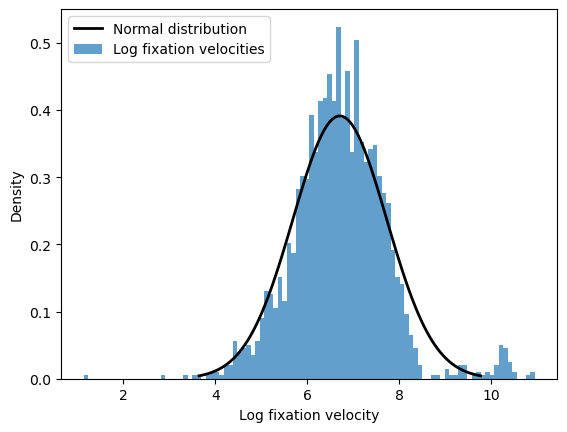

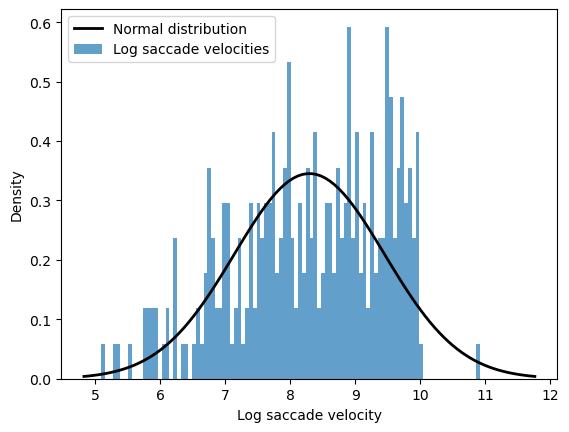

In [5]:
# Take the log of fixation velocities
log_fixation_velocities = np.log(fixation_velocities)

# Fit a normal distribution to the log fixation velocities
mu_f, std_f = norm.fit(log_fixation_velocities)

# Print the mean and standard deviation of the fitted distribution
print("Mean of log fixation velocities:", mu_f)
print("Standard deviation of log fixation velocities:", std_f)

# Take the log of fixation velocities
log_saccade_velocities = np.log(saccade_velocities)

# Fit a normal distribution to the log fixation velocities
mu_s, std_s = norm.fit(log_saccade_velocities)

# Print the mean and standard deviation of the fitted distribution
print("Mean of log saccade velocities:", mu_s)
print("Standard deviation of log saccade velocities:", std_s)

# Create a histogram of the log fixation velocities
plt.hist(np.log(fixation_velocities),100, density=True, alpha=0.7)

# Create a range of x values for the normal distribution
x = np.linspace(mu_f - 3*std_f, mu_f + 3*std_f, 100)

# Create the normal distribution using the mean and standard deviation
y_f = norm.pdf(x, mu_f, std_f)

# Plot the normal distribution on top of the histogram
plt.plot(x, y_f, 'k', linewidth=2)

# Add labels and a legend to the plot
plt.xlabel('Log fixation velocity')
plt.ylabel('Density')
plt.legend(['Normal distribution', 'Log fixation velocities'])

# Show the plot
plt.show()

# Create a histogram of the log fixation velocities
plt.hist(np.log(saccade_velocities),100, density=True, alpha=0.7)
# Create a range of x values for the normal distribution
x = np.linspace(mu_s - 3*std_s, mu_s + 3*std_s, 100)

# Create the normal distribution using the mean and standard deviation
y_s = norm.pdf(x, mu_s, std_s)

# Plot the normal distribution on top of the histogram
plt.plot(x, y_s, 'k', linewidth=2)

# Add labels and a legend to the plot
plt.xlabel('Log saccade velocity')
plt.ylabel('Density')
plt.legend(['Normal distribution', 'Log saccade velocities'])

# Show the plot
plt.show()
